# Preparing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

np.random.seed(10)
random.seed(10)

ratings = pd.read_csv("ratings.csv")
ratings.head()


,Unnamed: 0,userId,movieId,rating,timestamp
0,0,496,112852,3.0,1415520462
1,1,391,1947,4.0,1030945141
2,2,387,1562,1.5,1095041022
3,3,474,2716,4.5,1053020930
4,4,483,88125,4.5,1311337237


# Question 1A

In [2]:
user_id = ratings['userId'].values
movie_id = ratings['movieId'].values
rating = ratings['rating'].values

sparsity = len(rating) / (len(set(movie_id)) * len(set(user_id)))
print("Sparsity: ", sparsity)

Sparsity:  0.016999683055613623


# Question 1B

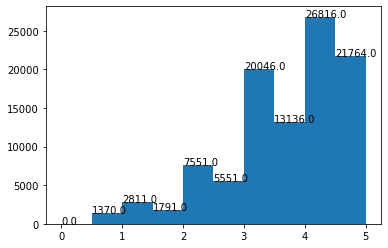

In [3]:
bins = np.linspace(0,5,num=11)
patches = plt.hist(rating, bins)

for i in range(10):
    plt.text(patches[1][i],patches[0][i],str(patches[0][i]))


# Question 1C

Text(0, 0.5, 'Number of ratings')

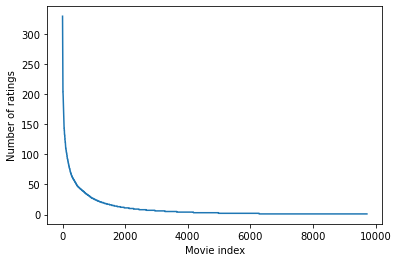

In [4]:
from collections import Counter

counterC = Counter(movie_id)
num_ratings = sorted(list(counterC.values()),reverse=True)
plt.plot(num_ratings)
plt.xlabel("Movie index")
plt.ylabel("Number of ratings")

# Question 1D

Text(0, 0.5, 'Number of ratings')

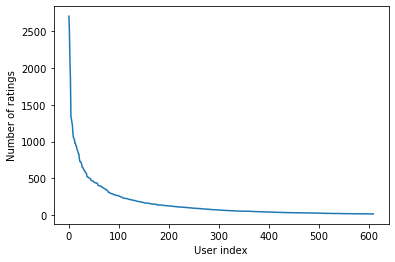

In [5]:
counterD = Counter(user_id)
num_users = sorted(list(counterD.values()),reverse=True)
plt.plot(num_users)
plt.xlabel("User index")
plt.ylabel("Number of ratings")


# Question 1E

# Question 1F

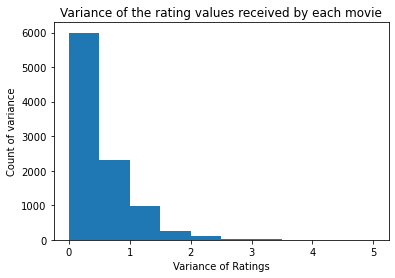

In [6]:
ratings_matrix = ratings.pivot(index = 'userId', columns = 'movieId', values = 'rating')
var_movie = np.var(ratings_matrix, axis=0)

plt.hist(var_movie, bins= np.linspace(0,5,num=11))
plt.title('Variance of the rating values received by each movie')
plt.xlabel('Variance of Ratings')
plt.ylabel('Count of variance')
plt.show()

# Question 2A

# Question 2B

# Question 3

# Question 4

In [7]:

from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

In [8]:
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
ratings_surprise = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

In [9]:
RMSE = []
MAE = []
for k in tqdm(range(2,102,2)):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'}, verbose=False)
    random.seed(10)
    np.random.seed(10)
    cv = cross_validate(knn, ratings_surprise, measures=['RMSE','MAE'],cv=10, verbose=False)
    RMSE.append(np.mean(cv['test_rmse']))
    MAE.append(np.mean(cv['test_mae']))
                

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:03<00:00, 13.27s/it]


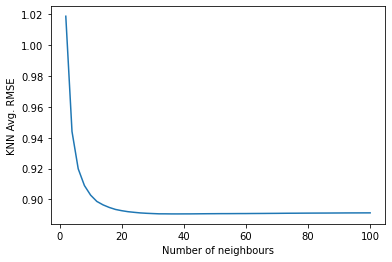

In [10]:
ks = np.arange(2,102,2)
plt.plot(ks, RMSE) 
plt.ylabel('KNN Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

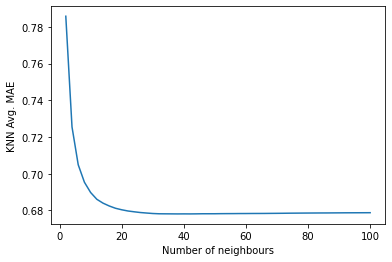

In [11]:
plt.plot(ks, MAE) 
plt.ylabel('KNN Avg. MAE')
plt.xlabel('Number of neighbours')
plt.show()

# Question 5

In [12]:
# absolute_min_RMSE = ks[RMSE.index(min(RMSE))]
# print(absolute_min_RMSE)
# absolute_min_RMSE = ks[MAE.index(min(MAE))]
# print(absolute_min_RMSE)


In [13]:
print('Average RMSE for KNN collaborative filter:', RMSE[20])
print('Average MAE for KNN collaborative filter:', MAE[20])

Average RMSE for KNN collaborative filter: 0.8906431823649316
Average MAE for KNN collaborative filter: 0.678099934962161


# Question 6

In [14]:
#['userId','movieId','rating']


In [15]:
ratings_raw = ratings_surprise.raw_ratings
user_rating_dic = {}
for item in ratings_raw:
    if item[1] not in user_rating_dic:
        user_rating_dic[item[1]] = []
    user_rating_dic[item[1]].append(item[2])

#user_rating_dic

varience_dic = {}
for i in user_rating_dic:
    varience_dic[i] = np.var(user_rating_dic[i])
    
popularmovie_trim = []
popularmovie_trim = [x for x in user_rating_dic if len(user_rating_dic[x]) > 2]
unpopularmovie_trim = []
unpopularmovie_trim = [x for x in user_rating_dic if len(user_rating_dic[x]) <= 2]
variance_trim = []
variance_trim = [x for x in user_rating_dic if len(user_rating_dic[x]) >= 5 and varience_dic[x] >= 2]

In [16]:
import time
time_start =time.time()
np.random.seed(10)
random.seed(10) 

knn_cv_10 = KFold(n_splits=10)
popular_knn_RMSE_total = []
unpopular_knn_RMSE_total = []
variance_knn_RMSE_total = []

ks = np.arange(2,102,2)
#ks = np.arange(2,4)
# result_q6 = []

for k in tqdm(ks):
    np.random.seed(10)
    random.seed(10) 
    popular_rmse_val = 0
    unpopular_rmse_val = 0
    variance_rmse_val = 0
    knn_Q6 = KNNWithMeans(k=k, sim_options = {'name': 'pearson'}, verbose=False)
    
    for train, test in knn_cv_10.split(ratings_surprise):
        
        knn_Q6.fit(train)

        popular_test = []
        popular_test = [x for x in test if x[1] in popularmovie_trim]
        popular_pred = knn_Q6.test(popular_test)
        popular_rmse_val += accuracy.rmse(popular_pred, verbose=False) 
        
        unpopular_test = []
        unpopular_test = [x for x in test if x[1] in unpopularmovie_trim]
        unpopular_pred = knn_Q6.test(unpopular_test)
        unpopular_rmse_val += accuracy.rmse(unpopular_pred, verbose=False)
        
        variance_test = []
        variance_test = [x for x in test if x[1] in variance_trim]
        variance_pred = knn_Q6.test(variance_test)
        variance_rmse_val += accuracy.rmse(variance_pred, verbose=False) 

    popular_knn_RMSE_total.append(popular_rmse_val / 10)
    unpopular_knn_RMSE_total.append(unpopular_rmse_val / 10)
    variance_knn_RMSE_total.append(variance_rmse_val / 10)
    
#     RMSE.append(np.mean(cv['test_rmse']))

print('\nTime to run code: {}'.format(time.time()-time_start))
                

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [17:53<00:00, 21.46s/it]


Time to run code: 1073.0220890045166


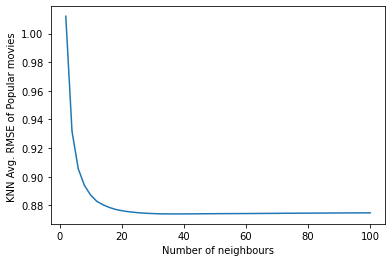

In [17]:
plt.plot(ks, popular_knn_RMSE_total)

plt.ylabel('KNN Avg. RMSE of Popular movies ')
plt.xlabel('Number of neighbours')
plt.show()

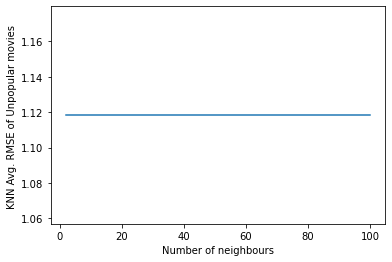

In [18]:
#plt.plot(ks, unpopular_knn_RMSE_total)
plt.plot(ks,unpopular_knn_RMSE_total)
plt.ylabel('KNN Avg. RMSE of Unpopular movies ')
plt.xlabel('Number of neighbours')
plt.show()

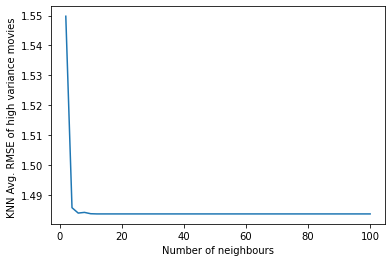

In [19]:
plt.plot(ks, variance_knn_RMSE_total)
plt.ylabel('KNN Avg. RMSE of high variance movies ')
plt.xlabel('Number of neighbours')
plt.show()

In [20]:
print('KNN Minimum average RMSE for popular movie', popular_knn_RMSE_total[20])
print('KNN Minimum average RMSE for unpopular movie', min(unpopular_knn_RMSE_total))
print('KNN Minimum average RMSE for high variance movie', min(variance_knn_RMSE_total))

KNN_min_RMSE_unpopular_index = ks[unpopular_knn_RMSE_total.index(min(unpopular_knn_RMSE_total))]
KNN_min_RMSE_variance_index = ks[variance_knn_RMSE_total.index(min(variance_knn_RMSE_total))]


KNN Minimum average RMSE for popular movie 0.8740885885547431
KNN Minimum average RMSE for unpopular movie 1.1183580423196242
KNN Minimum average RMSE for high variance movie 1.483615190158854


In [21]:
def find_best_pred(k, model_name, cat):
    random.seed(10)
    np.random.seed(10)
    cv_10 = KFold(n_splits=10)
    if model_name == 'knn':
        model = KNNWithMeans(k=k, sim_options = {'name': 'pearson'}, verbose = False)
    elif model_name == 'nmf':
        model = NMF(k) 
    elif model_name == 'svd':
        model = SVD(k)
        
    for train, test in cv_10.split(ratings_surprise):
        model.fit(train)
        testset = []
        if cat == 'popular':
            trim = popularmovie_trim
        elif cat == 'unpopular':
            trim = unpopularmovie_trim
        elif cat == 'variance':
            trim = variance_trim
        testset = [x for x in test if x[1] in trim]
        pred = model.test(testset)

    return pred

In [22]:
def plot_ROC(thres, pred):
    len_ = len(thres)
    fig, axes = plt.subplots(nrows=1, ncols=len_,figsize=(6*len_,6))
    for thre in thres:
        y_true = []
        for i in pred:
            if i.r_ui > thre:
                y_true.append(1)
            else:
                y_true.append(0)
        n = thres.index(thre)
        fpr, tpr, thresholds = roc_curve(y_true, [i.est for i in pred])
        axes[n].plot(fpr, tpr, lw=5, ls='--', color='r', label="AUC: {}, threshold={}".format((auc(fpr,tpr)), thre))
        axes[n].plot([0, 1], [0, 1], lw=2, ls='--', color='g') 
        axes[n].set_xlabel('FTR')
        axes[n].set_ylabel('TPR')
        axes[n].legend()
    plt.show()

In [23]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


# minimum k value for knn is 20 by eyeball
train_KNN, test_KNN = train_test_split(ratings_surprise, test_size=0.1)
pred_KNN  = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train_KNN).test(test_KNN)
thres = [2.5, 3.0, 3.5, 4.0]


ROC curves for the k-NN collaborative filters with 90% training set


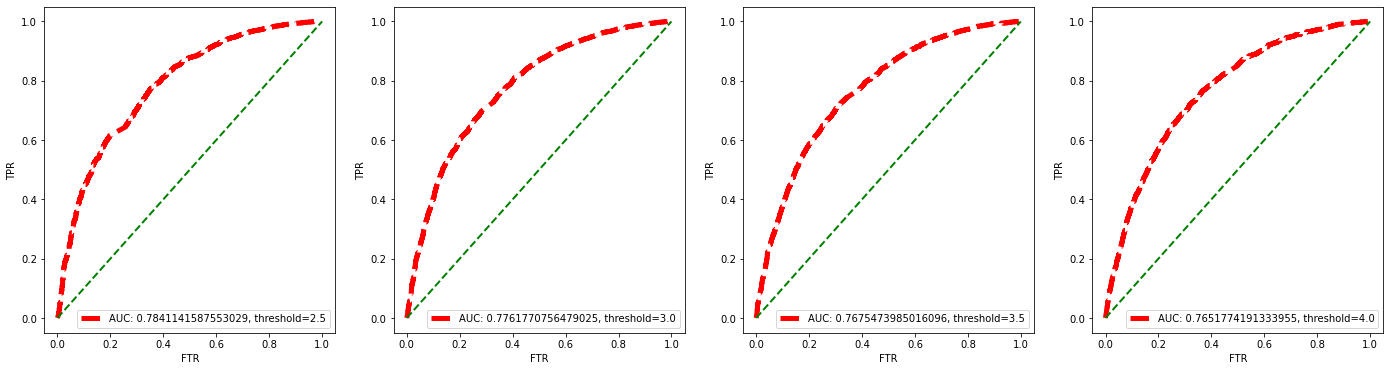

In [24]:
print('ROC curves for the k-NN collaborative filters with 90% training set')
plot_ROC(thres, pred_KNN)

ROC curves for the k-NN collaborative filters for popular movie trimming


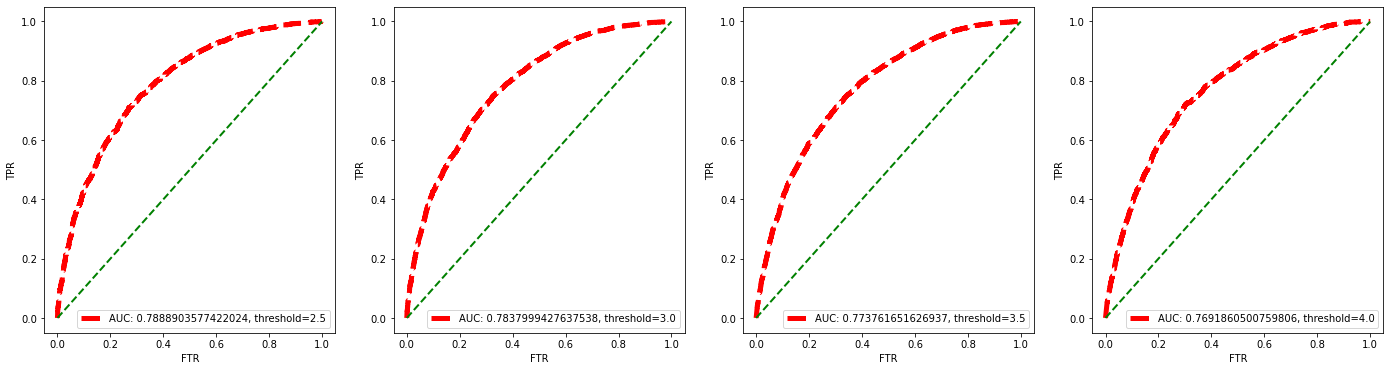

In [25]:
print('ROC curves for the k-NN collaborative filters for popular movie trimming')

popular_best_pred_knn = find_best_pred(20, 'knn', 'popular')
plot_ROC(thres, popular_best_pred_knn)

ROC curves for the k-NN collaborative filters for unpopular movie trimming


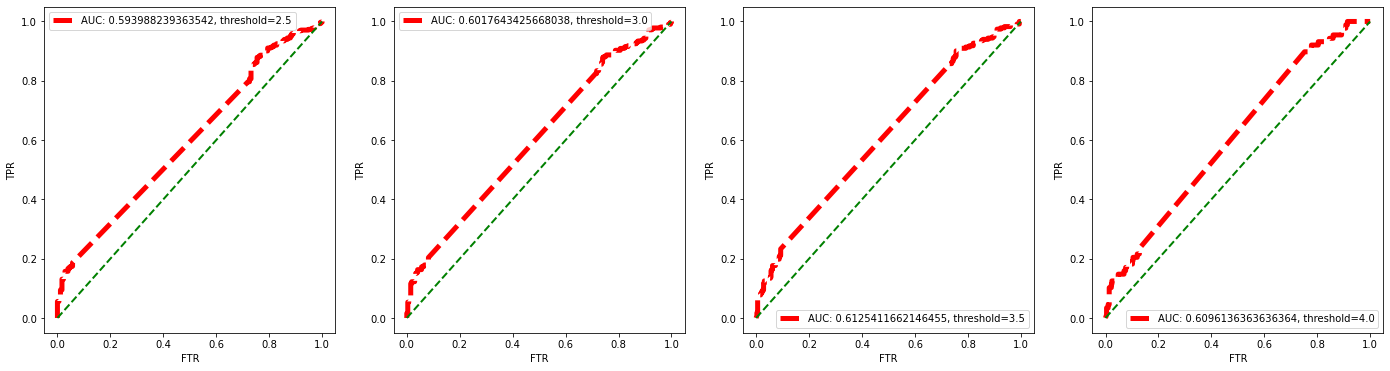

In [26]:
print('ROC curves for the k-NN collaborative filters for unpopular movie trimming')

unpopular_best_pred_knn = find_best_pred(KNN_min_RMSE_unpopular_index, 'knn', 'unpopular')
plot_ROC(thres, unpopular_best_pred_knn)

ROC curves for the k-NN collaborative filters for high variance movie trimming


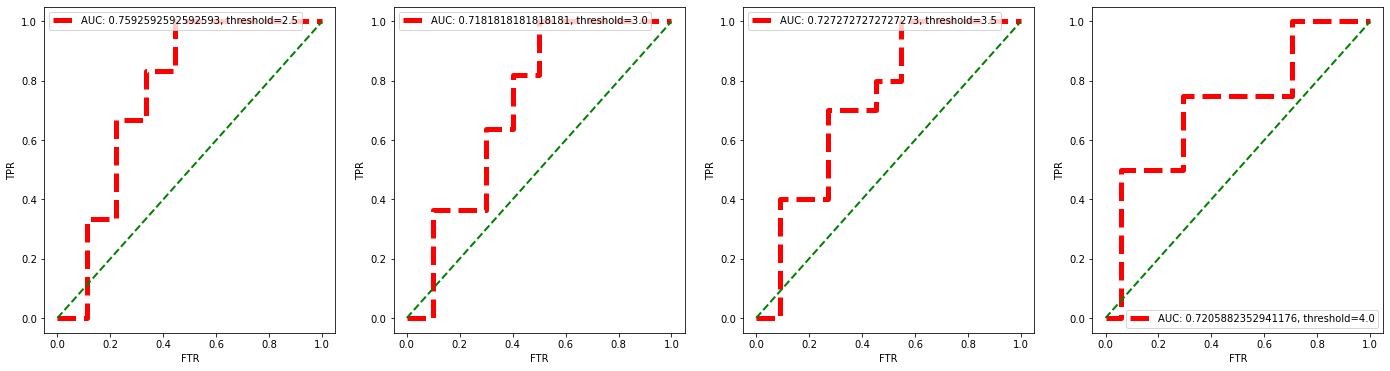

In [27]:
print('ROC curves for the k-NN collaborative filters for high variance movie trimming')

variance_best_pred_knn = find_best_pred(KNN_min_RMSE_variance_index, 'knn', 'variance')
plot_ROC(thres, variance_best_pred_knn)

# Question 7

# Question 8

In [28]:
from surprise.prediction_algorithms.matrix_factorization import NMF
time_start =time.time()

NMF_RMSE = []
NMF_MAE = []
ks_Q8 = np.arange(2,52,2)
for k in ks_Q8:
    nmf = NMF(k)
    cv = cross_validate(nmf, ratings_surprise, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    NMF_RMSE.append(np.mean(cv['test_rmse']))
    NMF_MAE.append(np.mean(cv['test_mae']))

print('\nTime to run code: {}'.format(time.time()-time_start))
                


Time to run code: 1791.9748933315277


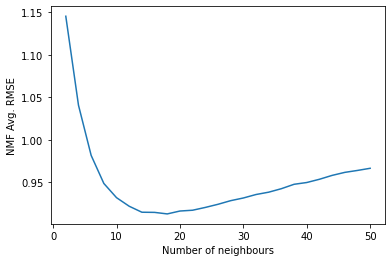

In [29]:
plt.plot(ks_Q8, NMF_RMSE) 
plt.ylabel('NMF Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

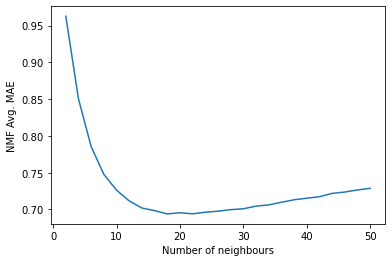

In [30]:
plt.plot(ks_Q8, NMF_MAE) 
plt.ylabel('NMF Avg. MAE')
plt.xlabel('Number of neighbours')
plt.show()

In [31]:
print("Average RMSE for NMF collaborative filter: {}, k is: {}".format(min(NMF_RMSE), ks_Q8[NMF_RMSE.index(min(NMF_RMSE))]))
print("Average MAE for NMF collaborative filter: {}, k is: {}".format(min(NMF_MAE), ks_Q8[NMF_MAE.index(min(NMF_MAE))]))

k_NMF = ks_Q8[NMF_RMSE.index(min(NMF_RMSE))]

Average RMSE for NMF collaborative filter: 0.9125778741903167, k is: 18
Average MAE for NMF collaborative filter: 0.6939573421921161, k is: 18


In [32]:
time_start =time.time()

np.random.seed(10)
random.seed(10) 
nmf_cv_10 = KFold(n_splits=10)
popular_nmf_RMSE_total = []
unpopular_nmf_RMSE_total = []
variance_nmf_RMSE_total = []

for k in tqdm(ks_Q8):
    np.random.seed(10)
    random.seed(10) 
    
    nmf_Q8 = NMF(k)
    popular_rmse_val = 0
    unpopular_rmse_val = 0
    variance_rmse_val = 0  
    
    for train, test in nmf_cv_10.split(ratings_surprise):
        
        nmf_Q8.fit(train)

        popular_test = []
        popular_test = [x for x in test if x[1] in popularmovie_trim]
        popular_pred_NMF = nmf_Q8.test(popular_test)
        popular_rmse_val += accuracy.rmse(popular_pred_NMF, verbose=False)
        
        unpopular_test = []
        unpopular_test = [x for x in test if x[1] in unpopularmovie_trim]
        unpopular_pred_NMF = nmf_Q8.test(unpopular_test)
        unpopular_rmse_val += accuracy.rmse(unpopular_pred_NMF, verbose=False)
        
        variance_test = []
        variance_test = [x for x in test if x[1] in variance_trim]
        variance_pred_NMF = nmf_Q8.test(variance_test)
        variance_rmse_val += accuracy.rmse(variance_pred_NMF, verbose=False)

    popular_nmf_RMSE_total.append(popular_rmse_val/10.0)
    unpopular_nmf_RMSE_total.append(unpopular_rmse_val/10.0)
    variance_nmf_RMSE_total.append(variance_rmse_val/10.0)

print('\nTime to run code: {}'.format(time.time()-time_start))     

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [33:21<00:00, 80.06s/it]


Time to run code: 2001.5407750606537


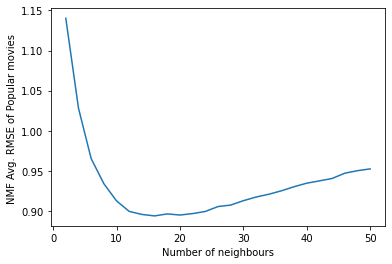

In [33]:
plt.plot(ks_Q8, popular_nmf_RMSE_total)
plt.ylabel('NMF Avg. RMSE of Popular movies ')
plt.xlabel('Number of neighbours')
plt.show()

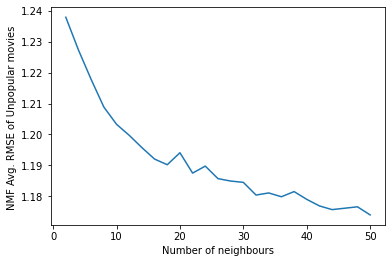

In [34]:
plt.plot(ks_Q8, unpopular_nmf_RMSE_total)
plt.ylabel('NMF Avg. RMSE of Unpopular movies ')
plt.xlabel('Number of neighbours')
plt.show()

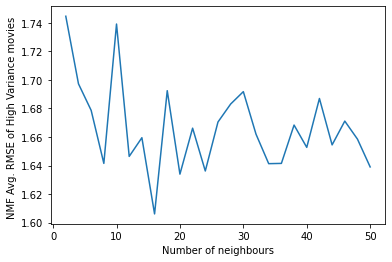

In [35]:
plt.plot(ks_Q8, variance_nmf_RMSE_total)
plt.ylabel('NMF Avg. RMSE of High Variance movies ')
plt.xlabel('Number of neighbours')
plt.show()

In [36]:
print('NMF Minimum average RMSE for popular movie', min(popular_nmf_RMSE_total))
print('NMF Minimum average RMSE for unpopular movie', min(unpopular_nmf_RMSE_total))
print('NMF Minimum average RMSE for high variance movie', min(variance_nmf_RMSE_total))


NMF_min_RMSE_popular_index = ks_Q8[popular_nmf_RMSE_total.index(min(popular_nmf_RMSE_total))]
NMF_min_RMSE_unpopular_index = ks_Q8[unpopular_nmf_RMSE_total.index(min(unpopular_nmf_RMSE_total))]
NMF_min_RMSE_variance_index = ks_Q8[variance_nmf_RMSE_total.index(min(variance_nmf_RMSE_total))]


NMF Minimum average RMSE for popular movie 0.8939432266639107
NMF Minimum average RMSE for unpopular movie 1.173941480208685
NMF Minimum average RMSE for high variance movie 1.6061148313268372


ROC curves for the NMF collaborative filters for popular movie trimming


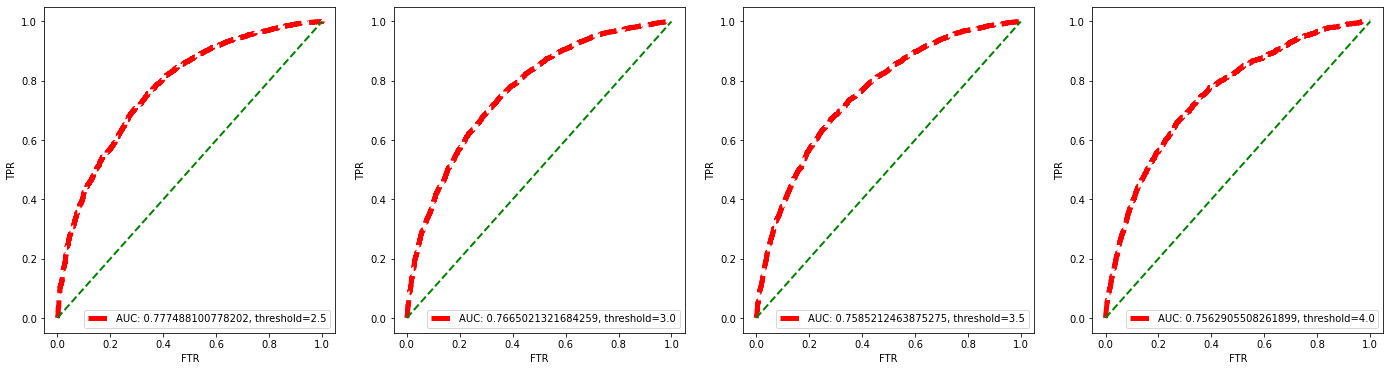

In [37]:
print('ROC curves for the NMF collaborative filters for popular movie trimming')
popular_best_pred_nmf = find_best_pred(NMF_min_RMSE_popular_index, 'nmf', 'popular')
plot_ROC(thres, popular_best_pred_nmf)


ROC curves for the NMF collaborative filters for unpopular movie trimming


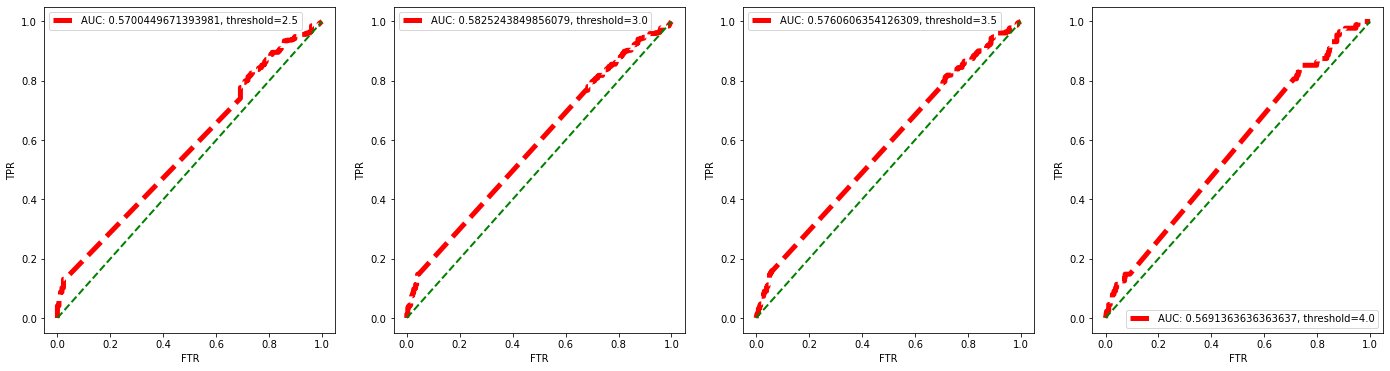

In [38]:
print('ROC curves for the NMF collaborative filters for unpopular movie trimming')
unpopular_best_pred_nmf = find_best_pred(NMF_min_RMSE_unpopular_index, 'nmf', 'unpopular')
plot_ROC(thres, unpopular_best_pred_nmf)

ROC curves for the NMF collaborative filters for variance movie trimming


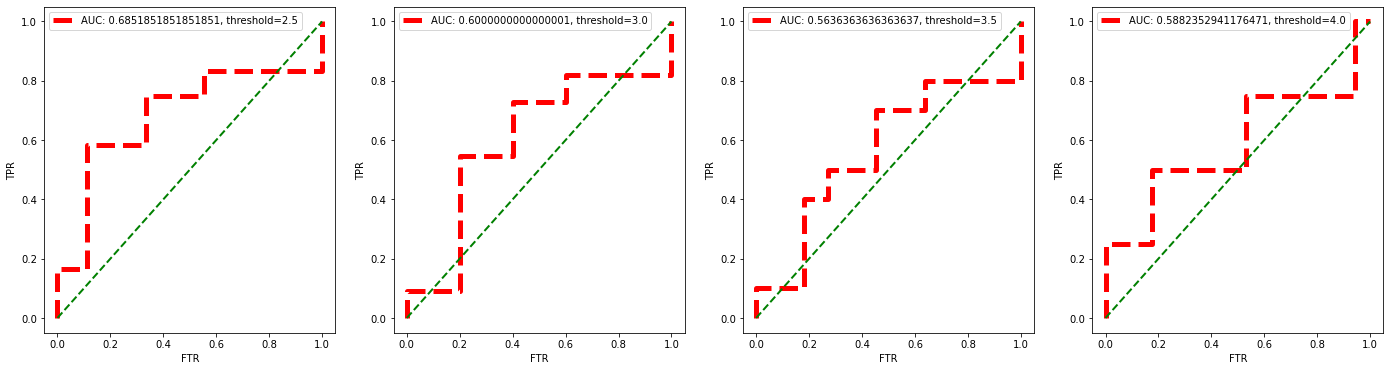

In [39]:
print('ROC curves for the NMF collaborative filters for variance movie trimming')
variance_best_pred_nmf = find_best_pred(NMF_min_RMSE_variance_index, 'nmf', 'variance')
plot_ROC(thres, variance_best_pred_nmf)

# Question 9

In [40]:
genre = pd.read_csv('movies.csv',usecols=['movieId','title','genres'])
train_NMF, test_NMF = train_test_split(ratings_surprise, test_size=0.1)
nmf_Q9 = NMF(20)
nmf_Q9.fit(train_NMF).test(test_NMF)

V = nmf_Q9.qi

In [41]:
for col in range(0,3):
    v_index = np.argsort(V[:, col])[::-1]
    print('column =', col)
    for i in v_index[:10]:
        print(genre['genres'][i])
    print('----------------------------------------------------------------')

column = 0
Comedy
Drama|Romance
Adventure|Children|Sci-Fi
Drama
Comedy|Drama
Drama|Mystery|Thriller
Documentary
Action|Animation|Children|Comedy
Comedy|Drama|Romance
Drama|Romance
----------------------------------------------------------------
column = 1
Comedy|Horror|Sci-Fi
Drama|Romance
Action|Animation|Fantasy|Sci-Fi
Action|Comedy|Fantasy
Comedy|Drama
Comedy
Comedy|Drama|Romance
Comedy|Drama
Crime|Drama|Thriller
Comedy|Romance
----------------------------------------------------------------
column = 2
Comedy|Musical|Romance
Drama
Documentary
Action|Comedy|Romance
Crime|Documentary
Comedy|Musical|Romance
Action|Drama|Thriller
Drama
Crime|Drama
Adventure|Children|Comedy
----------------------------------------------------------------


# Question 10

In [42]:
from surprise.prediction_algorithms.matrix_factorization import SVD
time_start =time.time()

SVD_RMSE = []
SVD_MAE = []
ks_Q10 = np.arange(2,52,2)
for k in ks_Q10:
    svd = SVD(k)
    cv = cross_validate(svd, ratings_surprise, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    SVD_RMSE.append(np.mean(cv['test_rmse']))
    SVD_MAE.append(np.mean(cv['test_mae']))

print('\nTime to run code: {}'.format(time.time()-time_start))




Time to run code: 537.6986312866211


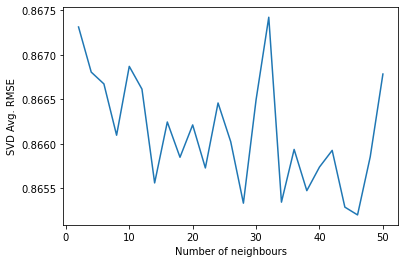

In [43]:
plt.plot(ks_Q10, SVD_RMSE) 
plt.ylabel('SVD Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

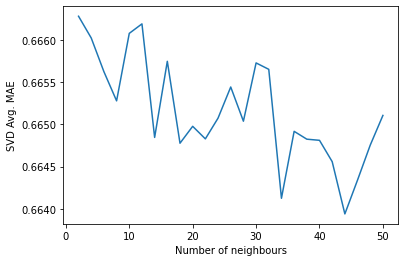

In [44]:
plt.plot(ks_Q10, SVD_MAE) 
plt.ylabel('SVD Avg. MAE')
plt.xlabel('Number of neighbours')
plt.show()

In [45]:
print("Average RMSE for MF collaborative filter: {}, k is: {}".format(min(SVD_RMSE), ks_Q10[SVD_RMSE.index(min(SVD_RMSE))]))
print("Average MAE for MF collaborative filter: {}, k is: {}".format(min(SVD_MAE), ks_Q10[SVD_MAE.index(min(SVD_MAE))]))

k_MF = ks_Q10[SVD_RMSE.index(min(SVD_RMSE))]

Average RMSE for MF collaborative filter: 0.8652007992734795, k is: 46
Average MAE for MF collaborative filter: 0.6639386364059771, k is: 44


In [46]:
time_start =time.time()

np.random.seed(10)
random.seed(10) 

svd_cv_10 = KFold(n_splits=10)
popular_svd_RMSE_total = []
unpopular_svd_RMSE_total = []
variance_svd_RMSE_total = []
    
for k in tqdm(ks_Q10):
    
    np.random.seed(10)
    random.seed(10) 
    svd_Q10 = SVD(k) 
    popular_rmse_val = 0
    unpopular_rmse_val = 0
    variance_rmse_val = 0
    
    for train, test in svd_cv_10.split(ratings_surprise):
          
        svd_Q10.fit(train)

        popular_test = []
        popular_test = [x for x in test if x[1] in popularmovie_trim]
        popular_pred_SVD = svd_Q10.test(popular_test)
        popular_rmse_val += accuracy.rmse(popular_pred_SVD, verbose=False)
        
        unpopular_test = []
        unpopular_test = [x for x in test if x[1] in unpopularmovie_trim]
        unpopular_pred_SVD = svd_Q10.test(unpopular_test)
        unpopular_rmse_val += accuracy.rmse(unpopular_pred_SVD, verbose=False)
        
        variance_test = []
        variance_test = [x for x in test if x[1] in variance_trim]
        variance_pred_SVD = svd_Q10.test(variance_test)
        variance_rmse_val += accuracy.rmse(variance_pred_SVD, verbose=False)

    popular_svd_RMSE_total.append(popular_rmse_val/10.0)
    unpopular_svd_RMSE_total.append(unpopular_rmse_val/10.0)
    variance_svd_RMSE_total.append(variance_rmse_val/10.0)

print('\nTime to run code: {}'.format(time.time()-time_start))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [12:35<00:00, 30.21s/it]


Time to run code: 755.2142839431763


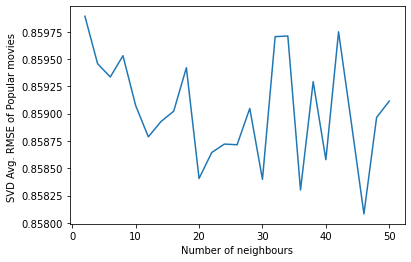

In [47]:
plt.plot(ks_Q10, popular_svd_RMSE_total)
plt.ylabel('SVD Avg. RMSE of Popular movies ')
plt.xlabel('Number of neighbours')
plt.show()

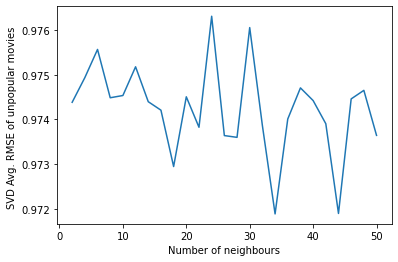

In [48]:
plt.plot(ks_Q10, unpopular_svd_RMSE_total)
plt.ylabel('SVD Avg. RMSE of unpopular movies ')
plt.xlabel('Number of neighbours')
plt.show()

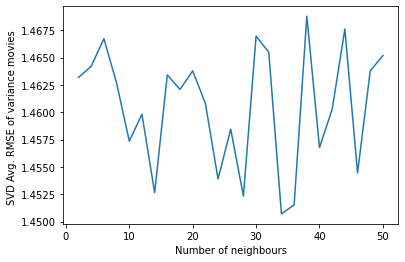

In [49]:
plt.plot(ks_Q10, variance_svd_RMSE_total)
plt.ylabel('SVD Avg. RMSE of variance movies ')
plt.xlabel('Number of neighbours')
plt.show()

In [50]:
print('SVD Minimum average RMSE for popular movie', min(popular_svd_RMSE_total))
print('SVD Minimum average RMSE for unpopular movie', min(unpopular_svd_RMSE_total))
print('SVD Minimum average RMSE for high variance movie', min(variance_svd_RMSE_total))

SVD_min_RMSE_popular_index = ks_Q10[popular_nmf_RMSE_total.index(min(popular_nmf_RMSE_total))]
SVD_min_RMSE_unpopular_index = ks_Q10[unpopular_nmf_RMSE_total.index(min(unpopular_nmf_RMSE_total))]
SVD_min_RMSE_variance_index = ks_Q10[variance_nmf_RMSE_total.index(min(variance_nmf_RMSE_total))]


SVD Minimum average RMSE for popular movie 0.858081375714006
SVD Minimum average RMSE for unpopular movie 0.971883228888276
SVD Minimum average RMSE for high variance movie 1.4507015236766354


ROC curves for the MF collaborative filters for popular movie trimming


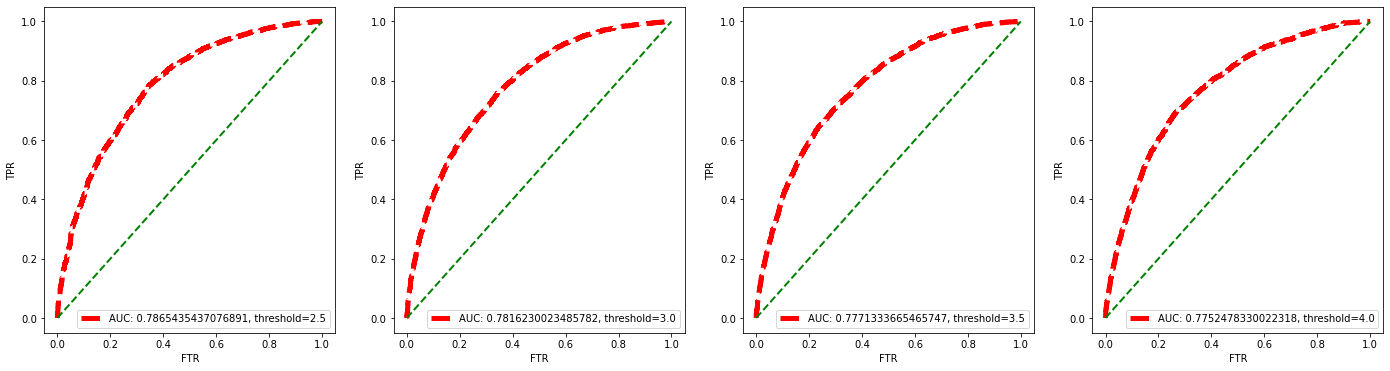

In [51]:
print('ROC curves for the MF collaborative filters for popular movie trimming')
popular_best_pred_svd = find_best_pred(SVD_min_RMSE_popular_index, 'svd', 'popular')
plot_ROC(thres, popular_best_pred_svd)


ROC curves for the MF collaborative filters for unpopular movie trimming


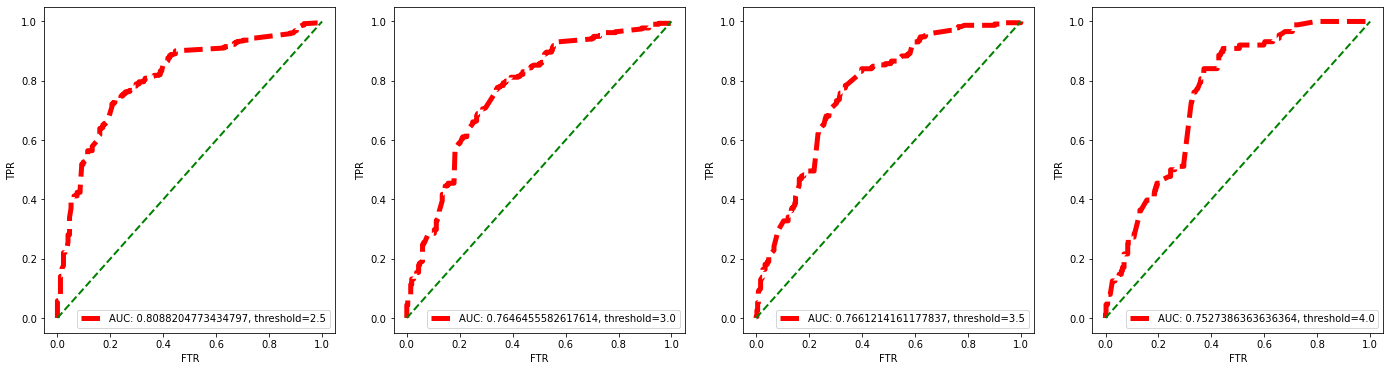

In [52]:
print('ROC curves for the MF collaborative filters for unpopular movie trimming')
unpopular_best_pred_svd = find_best_pred(SVD_min_RMSE_unpopular_index, 'svd', 'unpopular')
plot_ROC(thres, unpopular_best_pred_svd)


ROC curves for the MF collaborative filters for high variance movie trimming


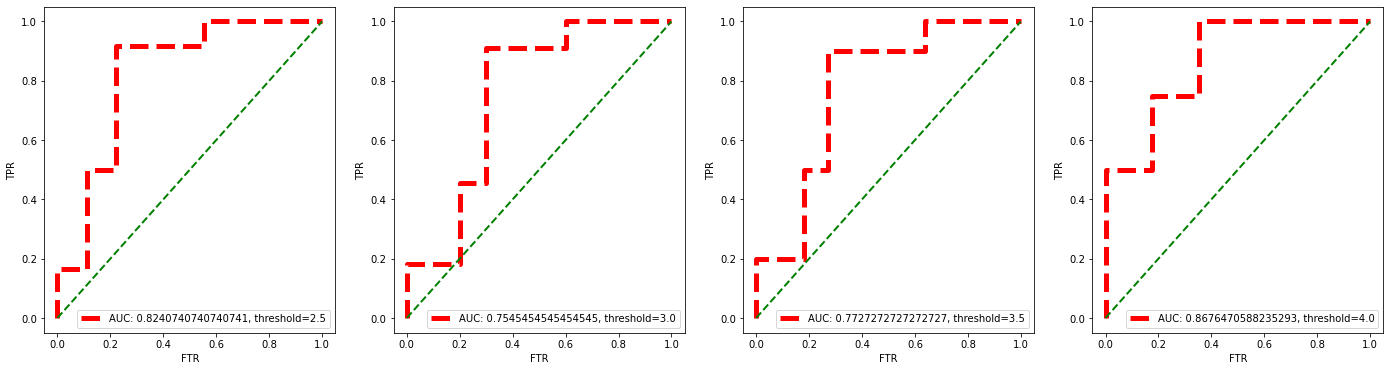

In [53]:
print('ROC curves for the MF collaborative filters for high variance movie trimming')
variance_best_pred_svd = find_best_pred(SVD_min_RMSE_variance_index, 'svd', 'variance')
plot_ROC(thres, variance_best_pred_svd)


# Question 11

In [54]:
from sklearn.metrics import mean_squared_error

ratings_raw = ratings_surprise.raw_ratings
all_user = {}
for i in ratings_raw:
    if i[0] in all_user.keys():
        all_user[i[0]].append(i[2])
    else:
        all_user[i[0]] = []
        all_user[i[0]].append(i[2])

user = {}
for i in all_user.keys():
    user[i] = np.mean(all_user[i])

naive_RMSE = 0
naive_cv_10 = KFold(n_splits=10)
for train, test in naive_cv_10.split(ratings_surprise):
    pred_naive = [user[i[0]] for i in test]
    true_naive = [i[2] for i in test]
    naive_RMSE += np.sqrt(mean_squared_error(true_naive,pred_naive))

avg_naive_RMSE = naive_RMSE / 10.0        


In [55]:
print("Average RMSE for naive collaborative filter: ", avg_naive_RMSE)

Average RMSE for naive collaborative filter:  0.9346962471248572


In [56]:
time_start =time.time()

popular_naive_RMSE_val = 0
unpopular_naive_RMSE_val = 0
variance_naive_RMSE_val = 0

for train, test in naive_cv_10.split(ratings_surprise):
    popular_test = []
    popular_test = [x for x in test if x[1] in popularmovie_trim]
    popular_true_naive = [i[2] for i in popular_test]
    popular_pred_naive = [user[i[0]] for i in popular_test]
    popular_naive_RMSE_val += np.sqrt(mean_squared_error(popular_true_naive, popular_pred_naive))
    
    unpopular_test = []
    unpopular_test = [x for x in test if x[1] in unpopularmovie_trim]
    unpopular_true_naive = [i[2] for i in unpopular_test]
    unpopular_pred_naive = [user[i[0]] for i in unpopular_test]
    unpopular_naive_RMSE_val += np.sqrt(mean_squared_error(unpopular_true_naive, unpopular_pred_naive))
    
    variance_test = []
    variance_test = [x for x in test if x[1] in variance_trim]
    variance_true_naive = [i[2] for i in variance_test]
    variance_pred_naive = [user[i[0]] for i in variance_test]
    variance_naive_RMSE_val += np.sqrt(mean_squared_error(variance_true_naive, variance_pred_naive))

avg_popular_naive_RMSE = popular_naive_RMSE_val / 10.0  
avg_unpopular_naive_RMSE = unpopular_naive_RMSE_val / 10.0   
avg_variance_naive_RMSE = variance_naive_RMSE_val / 10.0   
    
print('\nTime to run code: {}'.format(time.time()-time_start))


Time to run code: 9.64305305480957


In [57]:
print("Average RMSE for naive collaborative filter with popular Movie Trimming:", avg_popular_naive_RMSE)

Average RMSE for naive collaborative filter with popular Movie Trimming: 0.9323053680970579


In [58]:
print("Average RMSE for naive collaborative filter with unpopular Movie Trimming:", avg_unpopular_naive_RMSE)

Average RMSE for naive collaborative filter with unpopular Movie Trimming: 0.9704968354669647


In [59]:
print("Average RMSE for naive collaborative filter with variance Movie Trimming:", avg_variance_naive_RMSE)

Average RMSE for naive collaborative filter with variance Movie Trimming: 1.502179016093384


# Question 12

Computing the pearson similarity matrix...
Done computing similarity matrix.


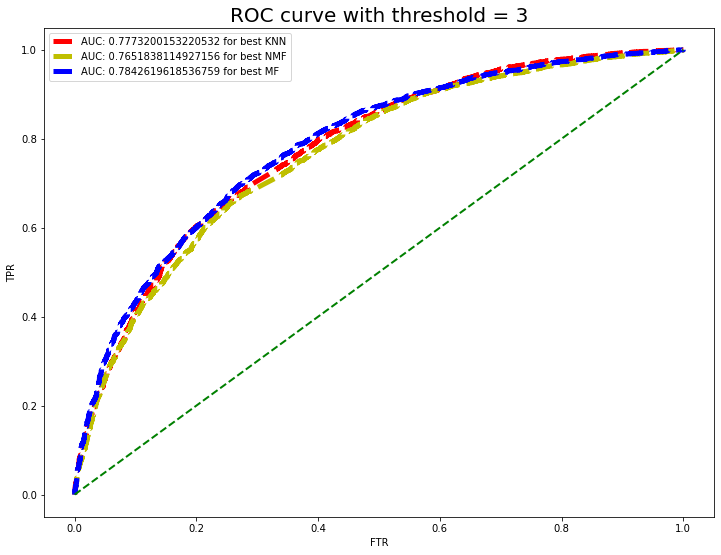

In [60]:
def find_best_roc(model):
    train, test = train_test_split(ratings_surprise, test_size=0.1)
    model.fit(train)
    pred = model.test(test)
    y_true = []
    for i in pred:
        if i.r_ui > 3:
            y_true.append(1)
        else:
            y_true.append(0)
    
    fpr, tpr, thresholds = roc_curve(y_true, [i.est for i in pred])
    return fpr, tpr

k_KNN = 20 

    
KNN_best = KNNWithMeans(k=k_KNN, sim_options = {'name': 'pearson'})
NMF_best = NMF(n_factors=k_NMF)
MF_best = SVD(n_factors=k_MF)

KNN_fpr, KNN_tpr = find_best_roc(KNN_best)
NMF_fpr, NMF_tpr = find_best_roc(NMF_best)
MF_fpr, MF_tpr = find_best_roc(MF_best)

plt.figure(figsize=(12,9))
plt.plot(KNN_fpr, KNN_tpr, lw=5, ls='--', color='r', label="AUC: {} for best KNN".format((auc(KNN_fpr,KNN_tpr))))
plt.plot(NMF_fpr, NMF_tpr, lw=5, ls='--', color='y', label="AUC: {} for best NMF".format((auc(NMF_fpr,NMF_tpr))))
plt.plot(MF_fpr, MF_tpr, lw=5, ls='--', color='b', label="AUC: {} for best MF".format((auc(MF_fpr,MF_tpr))))
plt.plot([0, 1], [0, 1], lw=2, ls='--', color='g') 
plt.xlabel('FTR')
plt.ylabel('TPR')
plt.title('ROC curve with threshold = 3', fontsize=20)
plt.legend()
plt.show()


# Question 13

# Question 14

In [67]:
from collections import defaultdict 

def predictions_(model_name):

    if model_name == 'knn':
        model = KNNWithMeans(k=k_KNN, sim_options = {'name': 'pearson'}, verbose=False)
    elif model_name == 'nmf':
        model = NMF(n_factors=k_NMF)
    elif model_name == 'mf':
        model = SVD(n_factors=k_MF)

    precision_arr = []
    recall_arr = []
    for t in tqdm(range(1,26)):
        cv = KFold(n_splits=10)
        p = []
        r = []
        for train, test in cv.split(ratings_surprise):
            model.fit(train)
            pred = model.test(test)
            
#             uid = np.asarray([i.uid for i in pred]) 
            
            user_est_true = defaultdict(list)
            for uid, _, true_r, est, _ in pred:
                user_est_true[uid].append((est, true_r))

            precisions = dict()
            recalls = dict()
            for uid, user_ratings in user_est_true.items():
                user_ratings.sort(key=lambda x: x[0], reverse=True)
                n_rel = sum((true_r >= 3) for (_, true_r) in user_ratings)
                n_rec_t = sum((est >= 3) for (est, _) in user_ratings[:t])
                n_rel_and_rec_t = sum(((true_r >= 3) and (est >= 3))
                                      for (est, true_r) in user_ratings[:t])
                precisions[uid] = n_rel_and_rec_t / n_rec_t if n_rec_t != 0 else 1
                recalls[uid] = n_rel_and_rec_t / n_rel if n_rel != 0 else 1
                
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        precision_arr.append(np.mean(np.array(p)))
        recall_arr.append(np.mean(np.array(r)))

    plt.plot(list(range (1,26)), precision_arr)
    plt.xlabel("t value")
    plt.ylabel("Precision")
    plt.title("The average precision plot using " + model_name)
    plt.show()
    
    plt.plot(list(range (1,26)), recall_arr)
    plt.xlabel("t value")
    plt.ylabel("Recall")
    plt.title("The average recall plot using " + model_name)
    plt.show()
    
    plt.plot(recall_arr, precision_arr)
    plt.xlabel("t value")
    plt.ylabel("Precision")
    plt.title("The average precision and recall plot using " + model_name)
    plt.show()

    return precision_arr, recall_arr 

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:40<00:00, 13.64s/it]


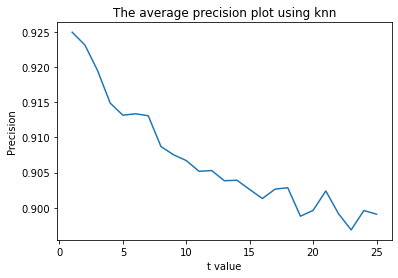

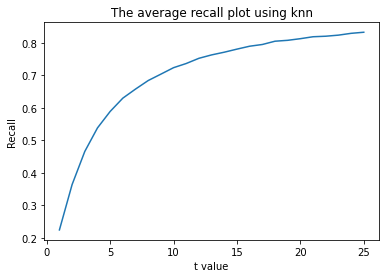

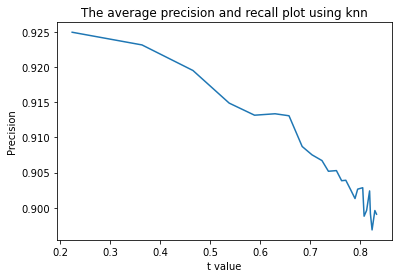


Time to run code: 341.19421887397766


In [68]:
time_start =time.time()
precision_knn, recall_knn = predictions_("knn")
print('\nTime to run code: {}'.format(time.time()-time_start))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [30:20<00:00, 72.81s/it]


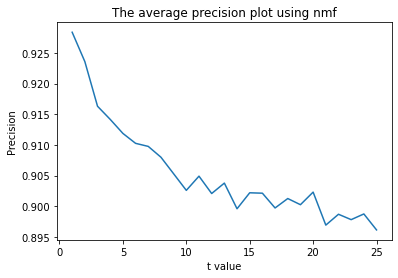

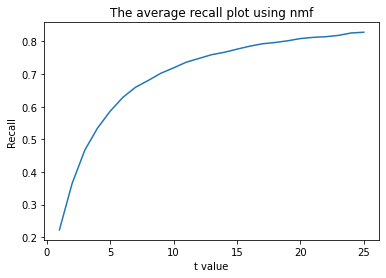

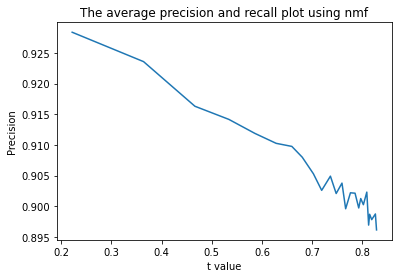


Time to run code: 1820.6104764938354


In [69]:
time_start =time.time()
precision_nmf, recall_nmf = predictions_("nmf")
print('\nTime to run code: {}'.format(time.time()-time_start))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [13:39<00:00, 32.78s/it]


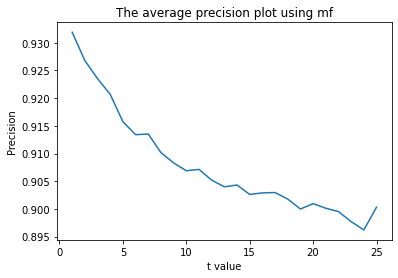

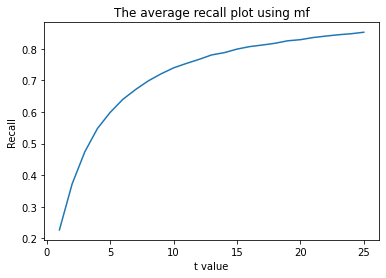

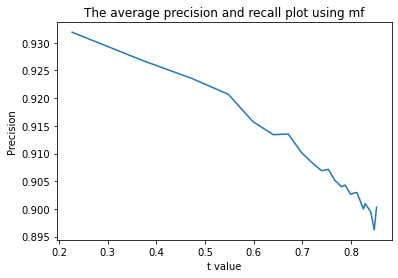


Time to run code: 820.0047876834869


In [70]:
time_start =time.time()
precision_svd, recall_svd = predictions_("mf")
print('\nTime to run code: {}'.format(time.time()-time_start))

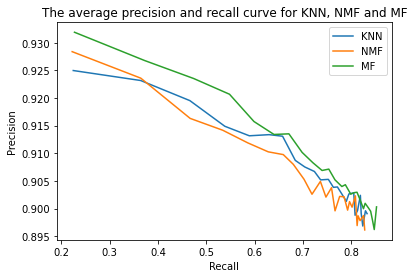

In [71]:
plt.plot(recall_knn, precision_knn, label = "KNN")
plt.plot(recall_nmf, precision_nmf, label = "NMF")
plt.plot(recall_svd, precision_svd, label = "MF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("The average precision and recall curve for KNN, NMF and MF")
plt.show()